<h4> Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.signal import lfilter
import scipy as sp

from math import sqrt as mathsqrt
from math import log as mathlog

from gym import Env
from gym.spaces import Discrete, Box

import os
import pickle

import torch as T
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.optim as optim

import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

from pprint import pprint as pp

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<h4> FEM dependencies

In [2]:
from feastruct.pre.material import Steel
from feastruct.pre.section import Section
import feastruct.fea.cases as cases
from feastruct.fea.frame_analysis import FrameAnalysis2D
from feastruct.solvers.naturalfrequency import NaturalFrequency
from feastruct.solvers.linstatic import LinearStatic
from feastruct.solvers.feasolve import SolverSettings

<h4> FORM dependencies

In [3]:
from FORM.ERANataf import ERANataf
from FORM.ERADist import ERADist

#### Run network on CUDA (GPU)

In [4]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

<h4> Finite Element Model Class

In [5]:

class FEModel():
    def __init__(self, L=4, storeys=3, qd=3.6):
        self.L = L
        self.numStoreys = storeys
        self.numCols = 2 * self.numStoreys
        self.numModes = self.numStoreys

        self.qd = qd

        self.crosSecs = {'beam' : {'name' : 'IPE220',
                                   'tf' : 0.0092, 
                                   'bf' : 0.110, 
                                   'hw' : 0.2016, 
                                   'tw' : 0.0059},
                         'col' : {'name' : 'HEA300',
                                  'tf' : 0.014, 
                                  'bf' : 0.300, 
                                  'hw' : 0.262, 
                                  'tw' : 0.0085}}
        # Define the cross-sections
        for cs in ('beam', 'col'):
            self.crosSecs[cs]['A0'] = 2 * self.crosSecs[cs]['tf'] * self.crosSecs[cs]['bf'] + self.crosSecs[cs]['tw'] * self.crosSecs[cs]['hw']
            self.crosSecs[cs]['I0'] = 2 * (self.crosSecs[cs]['bf'] * self.crosSecs[cs]['tf'] ** 3 / 12 + \
                                self.crosSecs[cs]['bf'] * self.crosSecs[cs]['tf'] * (self.crosSecs[cs]['hw'] / 2 + self.crosSecs[cs]['tf'] / 2) ** 2) + \
                                self.crosSecs[cs]['tw'] * self.crosSecs[cs]['hw'] ** 3 / 12
        # Create the node coordinates
        self.nodeCoords = [*[(0., k * self.L) for k in range(self.numStoreys + 1)],
                    *[(self.L, k * self.L) for k in range(self.numStoreys + 1)]]

        self.elemInfo = [{'start' : k, 'end' : k + 1, 'area' : self.crosSecs['col']['A0'], 'ixx' : self.crosSecs['col']['I0']} for k in range(self.numCols + 1) if k != self.numStoreys]

        self.elemInfo.extend([{'start' : k, 'end' : k + (self.numStoreys + 1), 'area' : self.crosSecs['beam']['A0'], 'ixx' : self.crosSecs['beam']['I0']} for k in [c for c in range(1, self.numStoreys+1)]])

        # Copy the element's info in order to change the damages in-place 
        self.defaultElemInfo = self.elemInfo.copy()

        # Store the Boundary Conditions' info
        self.bcInfo = {0 : (0, 1, 5),
                self.numStoreys + 1 : (0, 1, 5)}

        self.analysis = self._create_analysis(default=True)

        # Calculate the equivalent points loads applied to the nodes, to replace the triangular load
        elemDistLoadVals = {k : {"startLoad" : self.qd * self.analysis.elements[k].nodes[0].y / (3 * L),
                            "endLoad" : self.qd * self.analysis.elements[k].nodes[1].y / (3 * L)} for k in range(3)}

        elemPointForces = {k : {'start' : elemDistLoadVals[k]['startLoad'] * self.L / 3 + elemDistLoadVals[k]['endLoad'] * self.L / 6,
                            'end' : elemDistLoadVals[k]['startLoad'] * self.L / 6 + elemDistLoadVals[k]['endLoad'] * self.L / 3} for k in range(3)}

        self.nodeForces = [elemPointForces[0]['start'], *[elemPointForces[k]['end'] + elemPointForces[k+1]['start'] for k in range(2)], elemPointForces[2]['end']]

        # Assign the Boundary Conditions
        self.freedom_case = cases.FreedomCase()

        for nodeId, constDofs in self.bcInfo.items():
            for dofId in constDofs:
                self.freedom_case.add_nodal_support(node=self.analysis.nodes[nodeId], val=0, dof=dofId)

        # Assign the applied loads
        self.load_case = cases.LoadCase()

        for nodeId, loadVal in enumerate(self.nodeForces):
            self.load_case.add_nodal_load(node=self.analysis.nodes[nodeId], val=loadVal * 1e3, dof=0)

        # Set up the analysis case (BCs and Loads)
        self.analysis_case = cases.AnalysisCase(freedom_case=self.freedom_case, load_case=self.load_case)

        # Set up the settings for eigen- and linear static analysis
        self.settings = SolverSettings()
        self.settings.natural_frequency.time_info = False
        self.settings.linear_static.time_info = False
        self.settings.natural_frequency.num_modes = self.numModes

        eigSolver = NaturalFrequency(analysis=self.analysis, analysis_cases=[self.analysis_case], solver_settings=self.settings)
        linStatSolver = LinearStatic(analysis=self.analysis, analysis_cases=[self.analysis_case], solver_settings=self.settings)

        # Run the default analyses
        eigSolver.solve()
        linStatSolver.solve()

        self.undamagedEigmodes = [self.analysis.elements[0].get_frequency_results(analysis_case=self.analysis_case, frequency_mode=k)[0] for k in range(self.numModes)]
        self.undamagedModalDispls = np.array([[self.analysis.nodes[k].get_dofs([True, True, False, False, False, True])[0].get_frequency_mode(self.analysis_case, kk)[1] for k in [1, 2, 3, 5, 6, 7]] for kk in (0, 1, 2)])
        self.undamagedDrift = self.analysis.nodes[self.numStoreys].get_displacements(analysis_case=self.analysis_case)[0]
        
    def _create_analysis(self, mat=Steel(), default=False):
        # create 2d frame analysis object
        analysis = FrameAnalysis2D()

        # create nodes
        for coords in self.nodeCoords:
            analysis.create_node(coords=coords)

        elInfo = self.defaultElemInfo if default else self.elemInfo
        # create elements
        for elem in elInfo:
            analysis.create_element(
                el_type="EB2-2D",
                nodes=(analysis.nodes[elem['start']], analysis.nodes[elem['end']]),
                material=mat,
                section=Section(area=elem['area'], ixx=elem['ixx']))
        
        return analysis
    
    def eigen_analysis(self, damages):
        for k, dam in enumerate(damages):
            self.elemInfo[k]['area'], self.elemInfo[k]['ixx'], _ = self._calc_reduced_props(dam, self.crosSecs['col'])
    
            self.analysis = self._create_analysis()

        solver = NaturalFrequency(analysis=self.analysis, analysis_cases=[self.analysis_case], solver_settings=self.settings)

        solver.solve()

        return np.array([self.analysis.nodes[k].get_dofs([True, True, False, False, False, True])[0].get_frequency_mode(self.analysis_case, 0)[1] for k in [1, 2, 3, 5, 6, 7]])

    def linear_static_analysis(self, damages, node=3, dof=0):
        for k, dam in enumerate(damages):
            self.elemInfo[k]['area'], self.elemInfo[k]['ixx'], _ = self._calc_reduced_props(dam, self.crosSecs['col'])
    
            self.analysis = self._create_analysis()


        solver = LinearStatic(analysis=self.analysis, analysis_cases=[self.analysis_case], solver_settings=self.settings)

        solver.solve()

        # return the displacement along dof, for the input node
        return self.analysis.nodes[node].get_displacements(analysis_case=self.analysis_case)[dof]
    
    # Misc functions
    def _calc_reduced_props(self, ddet, crosSec):
        ddet = np.clip(ddet, a_min=0., a_max=0.999)

        A = 4.0
        B = 2 * (crosSec['tw'] - crosSec['hw'] - 2 * crosSec['tf'] - 2 * crosSec['bf'])
        C = ddet * crosSec['A0']

        c = (-B - np.sqrt(B ** 2 - 4 * A * C)) / (2 * A)

        A_ = 2 * (crosSec['tf'] - 2 * c) * (crosSec['bf'] - 2 * c) + (crosSec['tw'] - 2 * c) * (crosSec['hw'] + 2 * c)

        I_ = (
            2
            * (
                (crosSec['bf'] - 2 * c) * (crosSec['tf'] - 2 * c) ** 3 / 12
                + (crosSec['bf'] - 2 * c) * (crosSec['tf'] - 2 * c) * (crosSec['hw'] / 2 + crosSec['tf'] / 2) ** 2
            )
            + (crosSec['tw'] - 2 * c) * (crosSec['hw'] + 2 * c) ** 3 / 12
        )

        return A_, I_, c

    def _two_point_dist(self, p1, p2):
        return np.sqrt(np.sum((np.array(p1.coords) - np.array(p2.coords)) ** 2))

    def _element_length(self, elem):
        return self._two_point_dist(elem.nodes[0], elem.nodes[1])

    def _element_mass(self, elem):
        return elem.material.rho * elem.section.area * self._element_length(elem)

In [6]:
def FORM_geom(g, distr):
    # %% initial check if there exists a Nataf object
    if not (isinstance(distr, ERANataf)):
        raise RuntimeError("Incorrect distribution. Please create an ERANataf object!")

    d = len(distr.Marginals)

    # %% objective function
    dist_fun = lambda u: np.linalg.norm(u)

    # %% parameters of the minimize function
    u0 = 0.1 * np.ones(d)  # initial search point

    # nonlinear constraint: H(u) <= 0
    H = lambda u: g(distr.U2X(u))
    cons = {"type": "ineq", "fun": lambda u: -H(u)}

    # method for minimization
    alg = "SLSQP"

    # %% use constraint minimization
    res = sp.optimize.minimize(dist_fun, u0, constraints=cons, method=alg)

    # unpack results
    u_star = res.x
    beta = res.fun
    if np.all(u_star < 0):
        beta *= -1

    # compute design point in orignal space and failure probability
    Pf = sp.stats.norm.cdf(-beta)

    return Pf

<h3> Custom Environment

In [7]:
class frameEnv(Env):
    def __init__(self, noise, muA, muB, numSteps = 20, u=0.4/0.075**2, 
                 coeffVarA=0.5, coeffVarB=0.2, costReplace=10000, driftThres=0.024):

        self.model = FEModel()

        self.noise = noise
        self.muA = muA
        self.sigmaA = self.muA * coeffVarA
        self.muB = muB
        self.sigmaB = self.muB * coeffVarB
        self.u = u # the scale of the Gamma distributions
        self.R = np.eye(self.model.numCols) # correlation matrix for Nataf transformation

        self.logMuA = mathlog(self.muA**2/mathsqrt(self.muA**2+self.sigmaA**2))
        self.logSigmaA = mathsqrt(mathlog(1+self.sigmaA**2/self.muA**2))
 
        self.numSteps = numSteps
        self.action_space = Discrete(self.model.numCols * 3) # 0: do nothing, 1: repair, 2: replace
        self.observation_space = Box(-np.inf, np.inf, shape=(self.model.numCols * 2,), dtype=np.float32) 
        
        # Costs
        self.costReplace = -1 * costReplace
        self.costRepair = 0.5 * self.costReplace
        self.costFailure = self.model.numCols * self.costReplace

        self.failThres = driftThres

        # Reset the environment
        self.reset()

    def step(self, action):
        
        repairInds = action == 1 # the indices of the components that are being repaired
        replaceInds = action == 2 # the indices of the components that are being replaced

        self.ages[repairInds] = np.clip(self.ages[repairInds] - 2, a_min=0, a_max=None) # subtract 2 age steps for all components being repaired
        self.ages[replaceInds] = 0 # reset the ages of the replaced components
        self.shapes[replaceInds] = 0 # reset the shapes of the Gamma distribution of the damage for the replaced components

        # Bayesian inference
        # Updating the distributions of A, B
        self._bayesian_inference()

        reward = self._calc_pf_FORM() * self.costFailure + repairInds.sum() * self.costRepair + replaceInds.sum() * self.costReplace

        self.ages += 1
        self.decisionStep += 1
        
        done = True if self.decisionStep == self.numSteps else False
        info = {}

        return np.concatenate((self.shapes, self.ages)), reward, done, info
    

    def _bayesian_inference(self, draws=4000, tune=2000, targetAccept=0.9):
        
        with pm.Model() as bayesianInference:

            if self.decisionStep == 0:
                A = pm.Lognormal('A', mu=self.logMuA, sigma=self.logSigmaA)
                B = pm.Normal('B', mu=self.muB, sigma=self.sigmaB)
            else:
                A = self._from_posterior('A', self.trace['A'])
                B = self._from_posterior('B', self.trace['B'])
                
            # Sample a ann b for the components' damage increment distributions
            a = A.random(size=(self.model.numCols))
            b = B.random(size=(self.model.numCols))

            self.shapes += a * (self.ages + 1) ** b - a * self.ages ** b

            # create the continuous RV which is the expected value for the model
            damages = np.random.gamma(shape=self.shapes, scale=1/self.u, size=(5, self.model.numCols))

            modalDispls = np.mean(np.abs(np.array([self.model.eigen_analysis(dams) for dams in damages])), axis=0)

            obsMus = np.abs(self.model.eigen_analysis(np.random.gamma(shape=self.shapes, scale=1/self.u)))

            noises = obsMus * self.noise
            
            eigObs = np.random.normal(loc=obsMus, scale=noises)
            
            obsModalDispls = pm.Normal('observed', mu=modalDispls.reshape((-1, 1)), sigma=noises.reshape((-1, 1)), observed=eigObs.reshape((-1, 1)))

            self.trace = pm.sample(init='adapt_diag', progressbar=False)

    def _from_posterior(self, param, samples):
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)

        return pm.distributions.Interpolated(param, x, y)   

    def _calc_pf_MC(self, pfIters=5000): # Damages is an 1D numpy array containing the samples that were generated through NUTS
        damsPf = np.random.gamma(shape=self.shapes, scale=1/self.u, size=(pfIters, self.model.numCols))
        driftsPf = np.array([self.model.linear_static_analysis(ds) for ds in damsPf])

        return (driftsPf > self.failThres).sum() / pfIters
    
    def _calc_pf_FORM(self):

        pi_pdf = [ERADist('gamma', 'PAR', [self.u, sh]) for sh in self.shapes]
        pi_pdf = ERANataf(pi_pdf, self.R)
        g = lambda dams: np.abs(self.failThres - self.model.linear_static_analysis(np.array(dams)))
        pf = FORM_geom(g, pi_pdf)

        return pf

    def reset(self):
        self.decisionStep = 0
        self._new_struct()

        return np.concatenate((self.shapes, self.ages))
    
    def _new_struct(self):
        self.ages = np.zeros((self.model.numCols,))
        self.shapes = np.zeros((self.model.numCols,))

    def render(self):
        pass

    def close(self):
        pass

<h1> Proximal Policy Optimization (PPO)

<h4> PPO Rollout Buffer

In [8]:
class PPOMemory:
    def __init__(self, input_dims, n_comps, steps_per_epoch, gamma=0.99, lam=0.95):
        self.states = np.zeros((steps_per_epoch, input_dims), dtype=np.float32)
        self.probs = np.zeros(steps_per_epoch, dtype=np.float32)
        self.vals = np.zeros(steps_per_epoch, dtype=np.float32)
        self.actions = np.zeros((steps_per_epoch, n_comps), dtype=np.int32)
        self.rewards = np.zeros(steps_per_epoch, dtype=np.float32)
        self.returns = np.zeros(steps_per_epoch, dtype=np.float32)
        self.advantages = np.zeros(steps_per_epoch, dtype=np.float32)

        self.gamma, self.lam = gamma, lam
        self.mem_cntr, self.start_ind = 0, 0

    def store_memory(self, state, action, probs, vals, reward):
        self.states[self.mem_cntr] = state
        self.actions[self.mem_cntr] = action
        self.probs[self.mem_cntr] = probs
        self.vals[self.mem_cntr] = vals
        self.rewards[self.mem_cntr] = reward

        self.mem_cntr += 1
    
    def finish_path(self, last_val=0):
        path_slice = slice(self.start_ind, self.mem_cntr)
        rewards = np.append(self.rewards[path_slice], last_val)
        values = np.append(self.vals[path_slice], last_val)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantages[path_slice] = self._discounted_cumulative_sums(deltas, self.gamma * self.lam)
        self.returns[path_slice] = self._discounted_cumulative_sums(rewards, self.gamma)[:-1]

        self.start_ind = self.mem_cntr

    def _discounted_cumulative_sums(self, x, discount):
        return lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

<h4> PPO Actor Network

In [9]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, n_comps, input_dims, alpha, chkpt_dir, fc1_dims=256, fc2_dims=256):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, f"ppo_toy_actor.zip")

        self.n_comps = n_comps
        self.n_actions = n_actions
        self.actor = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)

    def forward(self, state):
        dist = self.actor(state)
        dist = T.reshape(dist, shape=(-1, self.n_comps, int(self.n_actions / self.n_comps)))
        soft = nn.Softmax(dim=2)
        dist = soft(dist)
        dist = Categorical(dist)

        return dist
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
    
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file, map_location=device))

<h4> PPO Critic Network

In [10]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, chkpt_dir, fc1_dims=256, fc2_dims=256):

        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, f"ppo_toy_critic.zip")

        self.critic = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(device)

    def forward(self, state):
        value = self.critic(state)

        return value
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
    
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file, map_location=device))

<h4> PPO Agent

In [11]:
class PPOAgent:
    def __init__(self, n_actions, input_dims, n_comps, steps_per_epoch, chkpt_dir, gamma=0.99, pi_lr=3e-4, v_lr=1e-3, gae_lambda=0.95, policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.n_comps = n_comps
        
        self.checkpoint_dir = chkpt_dir

        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

        self.actor = ActorNetwork(n_actions, n_comps, input_dims, pi_lr, chkpt_dir)
        self.critic = CriticNetwork(input_dims, v_lr, chkpt_dir)
        self.memory = PPOMemory(input_dims, n_comps, steps_per_epoch, gamma, gae_lambda)

    def remember(self, state, action, probs, vals, reward):
        self.memory.store_memory(state, action, probs, vals, reward)

    def choose_action(self, observation):
        state = T.tensor(np.array([observation]), dtype=T.float).to(device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action))
        action = T.squeeze(action)
        value = T.squeeze(value).item()
        
        # the probability of following the action VECTOR is the sum of 
        # the log_probs of the probabilities of each action
        prob = probs.sum()

        return action, prob, value

    def learn(self):
        self._normalize_advantages()
        advantages = T.tensor(self.memory.advantages).to(device)
        returns = T.tensor(self.memory.returns).to(device)

        for _ in range(self.n_epochs):

            permutation = T.randperm(self.steps_per_epoch)

            for i in range(0, self.steps_per_epoch, self.batch_size):
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()

                indices = permutation[i:i+self.batch_size]
                
                states = T.tensor(self.memory.states[indices], dtype=T.float).to(device)
                old_probs = T.tensor(self.memory.probs[indices]).to(device)
                actions = T.tensor(self.memory.actions[indices]).to(device)

                critic_values = self.critic(states)
                critic_values = T.squeeze(critic_values)

                dist = self.actor(states)
                new_probs = dist.log_prob(actions).sum(dim=1)

                actor_loss = self._comp_pi_loss(old_probs, new_probs, advantages[indices])
                critic_loss = self._comp_v_loss(returns[indices], critic_values)
                
                actor_loss.backward()
                critic_loss.backward()
                
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.mem_cntr, self.memory.start_ind = 0, 0
    
    def _comp_pi_loss(self, old_pi, new_pi, advs):
        prob_ratio = new_pi.exp() / old_pi.exp()
        weighted_probs = advs * prob_ratio
        weighted_clipped_probs = (T.clamp(prob_ratio, 1 - self.policy_clip, 1 + self.policy_clip) * advs)
        actor_loss = - T.min(weighted_probs, weighted_clipped_probs).mean()
        return actor_loss
    
    def _comp_v_loss(self, rets, vs):
        return ((rets - vs)**2).mean()
    
    def _normalize_advantages(self):
        self.memory.mem_cntr, self.memory.start_ind = 0, 0
        advantage_mean, advantage_std = (np.mean(self.memory.advantages), np.std(self.memory.advantages))

        self.memory.advantages = (self.memory.advantages - advantage_mean) / advantage_std
    
    def save_training(self, episodeScores, iterationScores):
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
        with open(os.path.join(self.checkpoint_dir, "ppo_scores"), "wb") as f:
            pickle.dump((episodeScores, iterationScores), f)
        
    def load_training(self):
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        with open(os.path.join(self.checkpoint_dir, "ppo_scores"), "rb") as f:
            episodeScores, iterationScores = pickle.load(f)
        
        return episodeScores, iterationScores

<h4> Problem Data

In [12]:
muA = 0.1
muB = 1.8

noise = 0.1 # coefficient of variation, meaning that sigma = omegaNoise * mu

env = frameEnv(noise, muA, muB)

<h4> Hyperparameters

In [18]:
steps_per_epoch = 400
batch_size = 80
n_epochs = 64
gamma = 0.99
clip_ratio = 0.10
policy_lr = 5e-6
value_func_lr = 1e-5
lam = 0.95

train_iters = 1
checkpoint_dir = "F:\\mindmap\\Tech\\thesisCode\\savedModels"

In [15]:
continue_flag = True

In [16]:
agent = PPOAgent(n_actions=env.action_space.n, input_dims=env.observation_space.shape[0], n_comps=env.model.numCols, 
                 steps_per_epoch=steps_per_epoch, chkpt_dir=checkpoint_dir, gamma=gamma, pi_lr=policy_lr, 
                 v_lr=value_func_lr, gae_lambda=lam, policy_clip=clip_ratio, batch_size=batch_size, n_epochs=n_epochs)

observation, episode_return, episode_length = env.reset(), 0, 0

if continue_flag:
    episode_score, iterScore = agent.load_training()
else:
    episode_score, iterScore = [], []

for i in range(train_iters):

    sum_return = 0
    num_episodes = 0

    t = 0

    while t < steps_per_epoch:

        action, prob, val = agent.choose_action(observation)
        action = action.cpu().numpy()

        try:
            observation_, reward, done, _ = env.step(action)
        except AssertionError:
            print("Assertion Error during sampling")
            t = (t // 20) * 20
            agent.memory.mem_cntr = t
            observation, episode_return, episode_length = env.reset(), 0, 0
            continue

        episode_return += reward

        agent.remember(observation, action, prob, val, reward)
        observation = observation_

        if done or (t == steps_per_epoch - 1):
            last_val = 0 if done else agent.critic(T.tensor(observation, dtype=T.float).to(device)).item()
            agent.memory.finish_path(last_val)
            sum_return += episode_return
            num_episodes += 1
            if done: episode_score.append(episode_return)
            observation, episode_return, episode_length = env.reset(), 0, 0
            print(f"Episode {num_episodes} is completed")
        t += 1
    
    agent.learn()
    tempScore = sum_return / num_episodes
    iterScore.append(tempScore)
    print(f"Iteration {i+1}, Average score {tempScore :.2f}")
    agent.save_training(episode_score, iterScore)

clear_output(wait=True)
print("PPO ran successfully")

PPO ran successfully


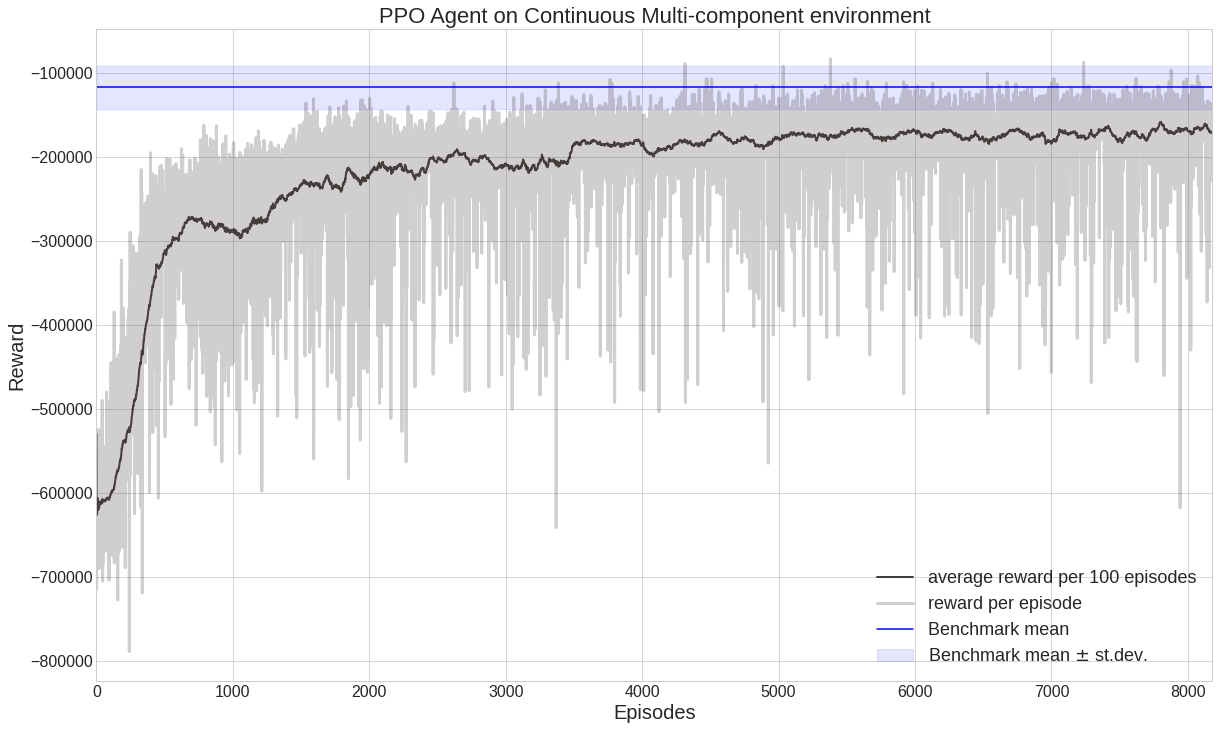

In [16]:
plt.style.use("seaborn-whitegrid")
color_ppo = '#453E3C'
avg_incr = 100

plt.figure(figsize=(20,12))
avg_ppo_scores = [np.mean(episode_score[max(0, i - avg_incr):(i + 1)]) for i in range(len(episode_score))]
plt.plot(list(range(len(avg_ppo_scores))), avg_ppo_scores, label=f'average reward per {avg_incr} episodes', linewidth=2, c=color_ppo)
plt.plot(list(range(len(episode_score))), episode_score, label='reward per episode', linewidth=3, alpha=0.25, c=color_ppo)

# cbmMean = -117819.96
# cbmStDev = 25854.85

# plt.axhline(cbmMean, color='blue', linewidth=1.5, label="Benchmark mean")
# plt.fill_between(x=list(range(len(avg_ppo_scores))), y1=cbmMean+cbmStDev, y2=cbmMean-cbmStDev, color='blue', alpha=0.1, label=r"Benchmark mean $\pm$ st.dev.")

plt.legend(fontsize=18, loc='lower right')
plt.xlabel('Episodes', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.xlim((0, len(episode_score)))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('PPO Agent on Continuous Multi-component environment', fontsize=22)
plt.show()
        

In [ ]:
len(episode_score)

8140

In [ ]:
agent = PPOAgent(n_actions=env.action_space.n, input_dims=env.observation_space.shape[0], n_comps=env.model.numCols, 
                 steps_per_epoch=steps_per_epoch, chkpt_dir=checkpoint_dir, gamma=gamma, pi_lr=policy_lr, 
                 v_lr=value_func_lr, gae_lambda=lam, policy_clip=clip_ratio, batch_size=batch_size, n_epochs=n_epochs)
episode_score, iterScore = agent.load_training()

In [ ]:
def policy_realization(agent, env):

    acts = np.zeros((env.numSteps, env.model.numCols))
    pfs = np.zeros((env.numSteps,))
    sts = np.zeros((env.numSteps + 1, env.model.numCols))
    cost = 0
    
    observation = env.reset()
    sts[0] = observation[:env.model.numCols]

    for decStep in range(env.numSteps):

        action, _, _ = agent.choose_action(observation)
        action = action.cpu().numpy()

        observation_, reward, _, _ = env.step(action)

        cost += reward
        acts[decStep] = action
        pfs[decStep] = env._calc_pf_FORM()
        sts[decStep + 1] = observation_[:env.model.numCols]

        observation = observation_
    
    return cost, acts, sts, pfs

<h3> Hardcoded constraints on policy

In [ ]:
def constrained_policy_realization(agent, env):

    acts = np.zeros((env.numSteps, env.model.numCols))
    pfs = np.zeros((env.numSteps,))
    sts = np.zeros((env.numSteps + 1, env.model.numCols))
    cost = 0
    
    observation = env.reset()
    sts[0] = observation[:env.model.numCols]

    for decStep in range(env.numSteps):

        if env.decisionStep < 4: # Do NOT take any action for the first four decision steps
            action = np.zeros((env.model.numCols,))
        else:
            action, _, _ = agent.choose_action(observation)
            action = action.cpu().numpy()

        undamComps = env.ages < 2
        action[undamComps] = 0

        observation_, reward, _, _ = env.step(action)

        cost += reward
        acts[decStep] = action
        pfs[decStep] = env._calc_pf_FORM()
        sts[decStep + 1] = observation_[:env.model.numCols]

        observation = observation_
    
    return cost, acts, sts, pfs